# Exercise

My step by step solutions enriched by [Saul's notes](https://drive.google.com/drive/folders/1EF6HW5NL9cM1hWLYa7bVL0bgMzEoqSBC)
Build a *blast-based* method to predict the presence of BPTI/Kunitz domain
in proteins available in SwissProt using the human proteins as a reference.
* Select all Proteins in SwissProt with BPTI/Kunitz domain.
* Separate human from non human proteins. Use the non human proteins
as a positive in the testing set.
* Generate a random set of negative of the same size of the positive set.
* Remove both positives and negatives from SwissProt and perform the
prediction based on the results of the blast search. 

checking the files we downloaded:

## The idea:
1. In swissprot: find all (human + non-human) Kunitz-containing proteins.
2. use the **non-human** fraction as a **positive training set**
3. Generate a **random** set of proteins as a negative set that has the same size as the positive set.
4. Then remove the training set and do a prediction based on a Blast search.

1. **Find human and non-human Kunitz proteins in SwissProt**
Searching all the human proteins in SwissProt containing the Kunitz domain.

`reviewed:yes organism:"Homo sapiens (Human) [9606]" database:(type:pfam PF00014)`

Retrieved 18 proteins. Download them in Fasta format.

In [1]:
grep '>'  Human_PF00014.fasta |wc

      18     200    1778


In [2]:
head Human_PF00014.fasta

>sp|Q06481|APLP2_HUMAN Amyloid-like protein 2 OS=Homo sapiens OX=9606 GN=APLP2 PE=1 SV=2
MAATGTAAAAATGRLLLLLLVGLTAPALALAGYIEALAANAGTGFAVAEPQIAMFCGKLN
MHVNIQTGKWEPDPTGTKSCFETKEEVLQYCQEMYPELQITNVMEANQRVSIDNWCRRDK
KQCKSRFVTPFKCLVGEFVSDVLLVPEKCQFFHKERMEVCENHQHWHTVVKEACLTQGMT
LYSYGMLLPCGVDQFHGTEYVCCPQTKIIGSVSKEEEEEDEEEEEEEDEEEDYDVYKSEF
PTEADLEDFTEAAVDEDDEDEEEGEEVVEDRDYYYDTFKGDDYNEENPTEPGSDGTMSDK
EITHDVKAVCSQEAMTGPCRAVMPRWYFDLSKGKCVRFIYGGCGGNRNNFESEDYCMAVC
KAMIPPTPLPTNDVDVYFETSADDNEHARFQKAKEQLEIRHRNRMDRVKKEWEEAELQAK
NLPKAERQTLIQHFQAMVKALEKEAASEKQQLVETHLARVEAMLNDRRRMALENYLAALQ
SDPPRPHRILQALRRYVRAENKDRLHTIRHYQHVLAVDPEKAAQMKSQVMTHLHVIEERR


Now I download all **non-Human** proteins that contain the **Kunitz Domain**: non human pf00014 file.

`database:(type:pfam pf00014) NOT organism:"Homo sapiens (Human) [9606]" AND reviewed:yes`

lets check how many sequences the fasta file contains.

In [4]:
grep '>' NotHuman_PF00014.fasta |wc

     341    3479   35934


In [5]:
head NotHuman_PF00014.fasta

>sp|P08592|A4_RAT Amyloid-beta A4 protein OS=Rattus norvegicus OX=10116 GN=App PE=1 SV=2
MLPSLALLLLAAWTVRALEVPTDGNAGLLAEPQIAMFCGKLNMHMNVQNGKWESDPSGTK
TCIGTKEGILQYCQEVYPELQITNVVEANQPVTIQNWCKRGRKQCKTHTHIVIPYRCLVG
EFVSDALLVPDKCKFLHQERMDVCETHLHWHTVAKETCSEKSTNLHDYGMLLPCGIDKFR
GVEFVCCPLAEESDSIDSADAEEDDSDVWWGGADTDYADGGEDKVVEVAEEEEVADVEEE
EAEDDEDVEDGDEVEEEAEEPYEEATERTTSIATTTTTTTESVEEVVREVCSEQAETGPC
RAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEYCMAVCGSVSSQSLLKTTSEPLPQD
PVKLPTTAASTPDAVDKYLETPGDENEHAHFQKAKERLEAKHRERMSQVMREWEEAERQA
KNLPKADKKAVIQHFQEKVESLEQEAANERQQLVETHMARVEAMLNDRRRLALENYITAL
QAVPPRPHHVFNMLKKYVRAEQKDRQHTLKHFEHVRMVDPKKAAQIRSQVMTHLRVIYER


These two sets are used as a positives set. The `Human_PF00014.fasta` as training positive and the the `NotHuman_PF00014.fasta` as testing positive set. 


And then we need a set that are for the **negatives**. So a set that are only Human but NOT PF00014 kunitz this dataset contains more than 20 000.

`NOT database:(type:pfam pf00014) AND organism:"Homo sapiens (Human) [9606]" AND reviewed:yes`

In [6]:
 grep '>' Human_NotPF00014.fasta |wc

   20347  222853 2042133


In [7]:
head Human_NotPF00014.fasta

>sp|Q8N8B7|TEANC_HUMAN Transcription elongation factor A N-terminal and central domain-containing protein OS=Homo sapiens OX=9606 GN=TCEANC PE=1 SV=2
MSDKNQIAARASLIEQLMSKRNFEDLGNHLTELETIYVTKEHLQETDVVRAVYRVLKNCP
SVALKKKAKCLLSKWKAVYKQTHSKARNSPKLFPVRGNKEENSGPSHDPSQNETLGICSS
NSLSSQDVAKLSEMIVPENRAIQLKPKEEHFGDGDPESTGKRSSELLDPTTPMRTKCIEL
LYAALTSSSTDQPKADLWQNFAREIEEHVFTLYSKNIKKYKTCIRSKVANLKNPRNSHLQ
QNLLSGTTSPREFAEMTVMEMANKELKQLRASYTESCIQEHYLPQVIDGTQTNKIKCRRC
EKYNCKVTVIDRGTLFLPSWVRNSNPDEQMMTYVICNECGEQWYHSKWVCW
>sp|O75494|SRS10_HUMAN Serine/arginine-rich splicing factor 10 OS=Homo sapiens OX=9606 GN=SRSF10 PE=1 SV=1
MSRYLRPPNTSLFVRNVADDTRSEDLRREFGRYGPIVDVYVPLDFYTRRPRGFAYVQFED
VRDAEDALHNLDRKWICGRQIEIQFAQGDRKTPNQMKAKEGRNVYSSSRYDDYDRYRRSR


## Creating Training and Testing Sets

1. Splitting the Human_NotPF00014.fasta File
Now if you want to split the dataset into 2 parts. Lets take the first 10000:

In [8]:
grep '>' Human_NotPF00014.fasta |wc -l

   20347


In [7]:
 grep '>' Human_NotPF00014.fasta |head -n 10000 |wc

   10000  109297 1005583


Then we can find the 'name' or ID of the 10 000st sequence:
By piping;

`head -- display first lines of a file`
`SYNOPSIS
     head [-n count | -c bytes] [file ...]`

`DESCRIPTION
     This filter displays the first count lines or bytes of each of the specified files, or
     of the standard input if no files are specified.  If count is omitted it defaults to
     10.` 
`tail -- display the last part of a file`
` -n number`

So we pipe the head of - n 10000 into | tail -n 1. That way we get the last of the list.

In [8]:
grep '>' Human_NotPF00014.fasta |head -n 10000 |tail -n 1

>sp|O95081|AGFG2_HUMAN Arf-GAP domain and FG repeat-containing protein 2 OS=Homo sapiens OX=9606 GN=AGFG2 PE=1 SV=2


Now that we have the name of the 10000st seq - we want to find the in which line number it is located.

In [9]:
grep -n O95081 Human_NotPF00014.fasta 

109065:>sp|O95081|AGFG2_HUMAN Arf-GAP domain and FG repeat-containing protein 2 OS=Homo sapiens OX=9606 GN=AGFG2 PE=1 SV=2


The sequence is found in the line `109065`. We can also retrieve the 10th line after the match:

In [11]:
grep -n -A 10 O95081 Human_NotPF00014.fasta #|less

109065:>sp|O95081|AGFG2_HUMAN Arf-GAP domain and FG repeat-containing protein 2 OS=Homo sapiens OX=9606 GN=AGFG2 PE=1 SV=2
109066-MVMAAKKGPGPGGGVSGGKAEAEAASEVWCRRVRELGGCSQAGNRHCFECAQRGVTYVDI
109067-TVGSFVCTTCSGLLRGLNPPHRVKSISMTTFTEPEVVFLQSRGNEVCRKIWLGLFDARTS
109068-LVPDSRDPQKVKEFLQEKYEKKRWYVPPDQVKGPTYTKGSASTPVQGSIPEGKPLRTLLG
109069-DPAPSLSVAASTSSQPVSQSHARTSQARSTQPPPHSSVKKASTDLLADIGGDPFAAPQMA
109070-PAFAAFPAFGGQTPSQGGFANFDAFSSGPSSSVFGSLPPAGQASFQAQPTPAGSSQGTPF
109071-GATPLAPASQPNSLADVGSFLGPGVPAAGVPSSLFGMAGQVPPLQSVTMGGGGGSSTGLA
109072-FGAFTNPFTAPAAQSPLPSTNPFQPNGLAPGPGFGMSSAGPGFPQAVPPTGAFASSFPAP
109073-LFPPQTPLVQQQNGSSFGDLGSAKLGQRPLSQPAGISTNPFMTGPSSSPFASKPPTTNPF
109074-L
109075->sp|P32970|CD70_HUMAN CD70 antigen OS=Homo sapiens OX=9606 GN=CD70 PE=1 SV=2


Knowing that one entry 'spans over' 10 lines - line one being the identifier and the remaining ones the sequence, we also know that we have to add 9 lines in order to 'keep' the whole sequence. As not to trucate it keeping only line one of it. The last line shold therefore be 109074.

(Or an easier way to approach it would have been to access sequence 100001 and find the number of the previous line...)

To check again that we calculated it right and we will obtain the entire seq of the sp|095081 we use head again: 

In [12]:
head -n 109074 Human_NotPF00014.fasta |tail -n 10

>sp|O95081|AGFG2_HUMAN Arf-GAP domain and FG repeat-containing protein 2 OS=Homo sapiens OX=9606 GN=AGFG2 PE=1 SV=2
MVMAAKKGPGPGGGVSGGKAEAEAASEVWCRRVRELGGCSQAGNRHCFECAQRGVTYVDI
TVGSFVCTTCSGLLRGLNPPHRVKSISMTTFTEPEVVFLQSRGNEVCRKIWLGLFDARTS
LVPDSRDPQKVKEFLQEKYEKKRWYVPPDQVKGPTYTKGSASTPVQGSIPEGKPLRTLLG
DPAPSLSVAASTSSQPVSQSHARTSQARSTQPPPHSSVKKASTDLLADIGGDPFAAPQMA
PAFAAFPAFGGQTPSQGGFANFDAFSSGPSSSVFGSLPPAGQASFQAQPTPAGSSQGTPF
GATPLAPASQPNSLADVGSFLGPGVPAAGVPSSLFGMAGQVPPLQSVTMGGGGGSSTGLA
FGAFTNPFTAPAAQSPLPSTNPFQPNGLAPGPGFGMSSAGPGFPQAVPPTGAFASSFPAP
LFPPQTPLVQQQNGSSFGDLGSAKLGQRPLSQPAGISTNPFMTGPSSSPFASKPPTTNPF
L


This way we have reconfirmed that the index of the last line we plan to grab is correct. Now we will save the sto of the following cmd to Humand_NotPF00014_Training.

### Now we actually split the set into 2:
in the outcome we want to keep

* 10000 proteins in the Training set - goes until line 109074
* 10347 in the Testing set - starts at line 109075

Generating the **Training set** :

In [13]:
head -n 109074 Human_NotPF00014.fasta > Human_NotPF00014_Training.fasta

Then we select the remaining ones as the **Testing set** by just modifying the cmd:

In [17]:
tail -n +109075 Human_NotPF00014.fasta > Human_NotPF00014_Testing.fasta

As always now we check weather the the files 'look' as we expect them to look:

In [18]:
grep '^>' Human_NotPF00014_Training.fasta |wc -l

   10000


In [19]:
grep '^>' Human_NotPF00014_Testing.fasta |wc -l

   10347


Prof Capriotti actually used:

`grep '>' Human_NotPF00014_Testing.fasta |wc
   10347  113556 1036550`
   


### Training and testing for the positives

In [18]:
# cat NotHuman_PF00014.fasta 

In [8]:
grep '>' NotHuman_PF00014.fasta |wc

     341    3479   35934


Find Uniport id of the 171th seq:

In [10]:
grep '>' NotHuman_PF00014.fasta |head -n 171 |tail -n 1

>sp|Q29428|TKDP1_SHEEP Trophoblast Kunitz domain protein 1 OS=Ovis aries OX=9940 GN=TKDP1 PE=2 SV=1


Find the last line of the seq by looking at that part in the file:
Last line of seq Q29428 is 928. So I will split the file here.

In [7]:
grep -n -A 11 Q29428 NotHuman_PF00014.fasta |cat

923:>sp|Q29428|TKDP1_SHEEP Trophoblast Kunitz domain protein 1 OS=Ovis aries OX=9940 GN=TKDP1 PE=2 SV=1
924-MRQLCLSTALLFLLVILVDSTPLNIYHIQDEGLETSHRRGPEKRSVIDVVSGIINGVATG
925-TKIIEKGAGILTGLAEIITKAIKGQVMISRIQFDNHTLEELPTLQLEYSTLSEENNGLKT
926-SHRRGLEKRSVTDVVTSIINGVATGTKIIEKGAGILTGLAEIITKAIKGQVMISGIQFDN
927-HTLEEYQTLKIEYSTLSEENKASKPALCLEPKVTGDCNATMTRYFYNTQTGLCEQFVYTG
928-CEGNGNNFENLEDCMKTCSQEAGSL
929->sp|Q9D263|SPIT4_MOUSE Kunitz-type protease inhibitor 4 OS=Mus musculus OX=10090 GN=Spint4 PE=2 SV=1
930-MKPTKLGFLLGLSLLCSLSPPVLSGVERLANYLCKDYNDPCLLDVEPGSCYEVHFRFFYN
931-QTAKQCQIFLFTGCNGNLNNFKLKIDCDVTCHETYKNPPLPSGDKRKRSLRALATKNLAT
932-DWRLTTLQPGRLRQTERKETLLQRARRESRRQPLARHHT
933->sp|B5L5R4|IVBI4_NOTSC Tigerin-4 OS=Notechis scutatus scutatus OX=70142 PE=3 SV=1
934-MSSGGLLLLLGLLTLWAELTPVSSKDRPKFCELPADSGPCRGILRAFYYHPVHRTCQMFI


Another way to find the right line to split on.

In [15]:
grep '>' NotHuman_PF00014.fasta -m 171 -n|tail -1
grep '>' NotHuman_PF00014.fasta -m 172 -n| tail -1

923:>sp|Q29428|TKDP1_SHEEP Trophoblast Kunitz domain protein 1 OS=Ovis aries OX=9940 GN=TKDP1 PE=2 SV=1
929:>sp|Q9D263|SPIT4_MOUSE Kunitz-type protease inhibitor 4 OS=Mus musculus OX=10090 GN=Spint4 PE=2 SV=1


### Splitting the positive not humansset into 2:
in the outcome we want to keep

* 171 proteins in the Training set - goes until line 928
* 170 in the Testing set - starts at line 929

Generating the **Training set** :

In [17]:
head -n 928 NotHuman_PF00014.fasta  > NotHuman_PF00014_Training.fasta
tail  -n +929 NotHuman_PF00014.fasta  > NotHuman_PF00014_Testing.fasta
grep ">" NotHuman_PF00014_Training.fasta|tail -1
cat NotHuman_PF00014_Testing.fasta|head -1

>sp|Q29428|TKDP1_SHEEP Trophoblast Kunitz domain protein 1 OS=Ovis aries OX=9940 GN=TKDP1 PE=2 SV=1
>sp|Q9D263|SPIT4_MOUSE Kunitz-type protease inhibitor 4 OS=Mus musculus OX=10090 GN=Spint4 PE=2 SV=1


## Creating the BLAST database

For the human proteins set with the new version of BLAST
Now we have to format the Database:
If you want to format a database
The DB now uses as a reference the human BPTI domain. `formatdb -i <file name> -p T`

Problem on my machine the formatdb is deprecated... instead I had to use:

See: https://www.ncbi.nlm.nih.gov/books/NBK279690/ 

In [10]:
#makeblastdb -in Human_PF00014.fasta -taxid 9606 -dbtype prot

In [11]:
#makeblastdb -in Human_PF00014.fasta -dbtype prot



Building a new DB, current time: 04/21/2020 15:47:52
New DB name:   /Users/ila/01-Unibo/2_LAB1_2nd/capriotti/repkunitz/Human_PF00014.fasta
New DB title:  Human_PF00014.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /Users/ila/01-Unibo/2_LAB1_2nd/capriotti/repkunitz/Human_PF00014.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 18 sequences in 0.0606122 seconds.


`Building a new DB, current time: 04/16/2020 18:24:24
New DB name:   /Users/ila/01-Unibo/2_LAB1_2nd/capriotti/repkunitz/Human_PF00014.fasta
New DB title:  Human_PF00014.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 18 sequences in 0.0149059 seconds.`

In [12]:
ls

Exercise_Report.ipynb           Human_PF00014.fasta.phr
Human_NotPF00014.fasta          Human_PF00014.fasta.pin
Human_NotPF00014_Testing.fasta  Human_PF00014.fasta.psq
Human_NotPF00014_Training.bl6   NotHuman_PF00014.bl6
Human_NotPF00014_Training.fasta NotHuman_PF00014.bl6.best
Human_PF00014.bl6               NotHuman_PF00014.fasta
Human_PF00014.bl8               bl8
Human_PF00014.fasta             kunitz_meeting.rtf


`ila@Immanuelas-Air:~/01-Unibo/2_LAB1_2nd/capriotti/repkunitz$ ls
13L_lab1-15-04_all.mp4          Human_PF00014.fasta             NotHuman_PF00014.fasta
Human_NotPF00014.fasta          Human_PF00014.fasta.phr         ncbi-blast-2.2.26+.dmg
Human_NotPF00014_Testing.fasta  Human_PF00014.fasta.pin         not_not.fasta
Human_NotPF00014_Training.fasta Human_PF00014.fasta.psq`

Now just to check, we will do the blast of the 
human proteins against the Human proteins just as a consistency test. The evalue was increased just to see what happenes.
`#replacing blastpgp from version 2.2.26 (legacy) -i = -query, -d = -db, -o = -out, -m = -outfmt. `


In [33]:
# outfmt 6 is the Tabular form
#psiblast -query Human_PF00014.fasta -db Human_PF00014.fasta -out Human_PF00014.bl6 -outfmt 6
blastp -query Human_PF00014.fasta -db Human_PF00014.fasta -out autotest.bltab -outfmt 6 -evalue 1000 # -m 8 of the old version7
blastp -query Human_PF00014.fasta -db Human_PF00014.fasta -out Human_PF00014.bl6 -outfmt 6 -evalue 1000 #

The output was redirected into the `Human_PF00014.bl6` file
looking like that:

In [32]:
head Human_PF00014.bl6

sp|Q06481|APLP2_HUMAN	sp|Q06481|APLP2_HUMAN	100.000	763	0	0	1	763	1	763	0.0	1590
sp|Q06481|APLP2_HUMAN	sp|P05067|A4_HUMAN	51.111	495	178	11	313	762	294	769	1.73e-155	463
sp|Q06481|APLP2_HUMAN	sp|O43291|SPIT2_HUMAN	41.667	84	47	1	288	369	111	194	8.02e-21	84.0
sp|Q06481|APLP2_HUMAN	sp|O43291|SPIT2_HUMAN	40.625	64	34	2	298	360	28	88	2.75e-14	64.7
sp|Q06481|APLP2_HUMAN	sp|O43291|SPIT2_HUMAN	25.806	31	19	1	108	134	154	184	169	15.8
sp|Q06481|APLP2_HUMAN	sp|O43291|SPIT2_HUMAN	62.500	8	3	0	539	546	225	232	307	15.0
sp|Q06481|APLP2_HUMAN	sp|O43291|SPIT2_HUMAN	33.333	18	10	1	193	210	125	140	932	13.5
sp|Q06481|APLP2_HUMAN	sp|P49223|SPIT3_HUMAN	47.170	53	28	0	309	361	35	87	5.02e-16	65.1
sp|Q06481|APLP2_HUMAN	sp|P49223|SPIT3_HUMAN	29.412	17	12	0	76	92	71	87	171	15.4
sp|Q06481|APLP2_HUMAN	sp|P49223|SPIT3_HUMAN	80.000	5	1	0	621	625	39	43	362	14.2


Both top and bottom show lines for which the first 2 cols are equal which means that they are matching against them selves.

In [31]:
awk '{if ($1 == $2) print $0}' autotest.bltab 

sp|Q06481|APLP2_HUMAN	sp|Q06481|APLP2_HUMAN	100.000	763	0	0	1	763	1	763	0.0	1590
sp|P05067|A4_HUMAN	sp|P05067|A4_HUMAN	100.000	770	0	0	1	770	1	770	0.0	1610
sp|Q02388|CO7A1_HUMAN	sp|Q02388|CO7A1_HUMAN	100.000	2944	0	0	1	2944	1	2944	0.0	5494
sp|P12111|CO6A3_HUMAN	sp|P12111|CO6A3_HUMAN	100.000	3177	0	0	1	3177	1	3177	0.0	6455
sp|P02760|AMBP_HUMAN	sp|P02760|AMBP_HUMAN	100.000	352	0	0	1	352	1	352	0.0	734
sp|O95925|EPPI_HUMAN	sp|O95925|EPPI_HUMAN	100.000	133	0	0	1	133	1	133	8.42e-100	274
sp|P10646|TFPI1_HUMAN	sp|P10646|TFPI1_HUMAN	100.000	304	0	0	1	304	1	304	0.0	630
sp|O43278|SPIT1_HUMAN	sp|O43278|SPIT1_HUMAN	100.000	529	0	0	1	529	1	529	0.0	1099
sp|O43291|SPIT2_HUMAN	sp|O43291|SPIT2_HUMAN	100.000	252	0	0	1	252	1	252	0.0	521
sp|P48307|TFPI2_HUMAN	sp|P48307|TFPI2_HUMAN	100.000	235	0	0	1	235	1	235	2.53e-180	486
sp|Q8TEU8|WFKN2_HUMAN	sp|Q8TEU8|WFKN2_HUMAN	100.000	576	0	0	1	576	1	576	0.0	1199
sp|Q2UY09|COSA1_HUMAN	sp|Q2UY09|COSA1_HUMAN	100.000	1125	0	0	1	1125	1	1125	0.0	2187
sp|Q96NZ8|WFKN1_HUMAN	

In [ ]:
# sp|Q06481|APLP2_HUMAN   sp|Q06481|APLP2_HUMAN   100.000 763     0       0       1       763     1       763     0.0     1590
# sp|Q06481|APLP2_HUMAN   sp|P05067|A4_HUMAN      51.111  495     178     11      313     762     294     769     1.73e-155       463
# sp|Q06481|APLP2_HUMAN   sp|O43291|SPIT2_HUMAN   41.667  84      47      1       288     369     111     194     8.02e-21        84.0
# sp|Q06481|APLP2_HUMAN   sp|O43291|SPIT2_HUMAN   40.625  64      34      2       298     360     28      88      2.75e-14        64.7
# sp|Q06481|APLP2_HUMAN   sp|P49223|SPIT3_HUMAN   47.170  53      28      0       309     361     35      87      5.02e-16        65.1

The 11th column shows the e-value. To find the highest (=worst) e-value we use reverse sort by 11th column. `-nrk n- number, r- reverse, k- column`

In [19]:
sort -nrk 11 Human_PF00014.bl8 |head #|less

sp|Q9BQY6|WFDC6_HUMAN	sp|Q02388|CO7A1_HUMAN	48.000	25	11	2	12	35	2315	2338	10.0	16.9
sp|P10646|TFPI1_HUMAN	sp|P12111|CO6A3_HUMAN	45.098	51	28	0	217	267	3112	3162	9.99e-12	56.6
sp|P02760|AMBP_HUMAN	sp|Q9BQY6|WFDC6_HUMAN	59.259	27	11	0	256	282	102	128	9.98e-06	35.8
sp|O95428|PPN_HUMAN	sp|P02760|AMBP_HUMAN	38.462	52	32	0	754	805	231	282	9.96e-10	52.4
sp|Q8TEU8|WFKN2_HUMAN	sp|O43278|SPIT1_HUMAN	54.545	44	20	0	393	436	398	441	9.95e-11	54.7
sp|Q02388|CO7A1_HUMAN	sp|P12111|CO6A3_HUMAN	23.721	215	149	8	1025	1233	12	217	9.92e-06	41.6
sp|Q96NZ8|WFKN1_HUMAN	sp|P10646|TFPI1_HUMAN	29.545	132	59	1	313	410	137	268	9.91e-16	68.9
sp|P12111|CO6A3_HUMAN	sp|Q2UY09|COSA1_HUMAN	24.828	145	96	3	1639	1778	798	934	9.90e-06	41.6
sp|Q8IUA0|WFDC8_HUMAN	sp|P12111|CO6A3_HUMAN	66.667	6	2	0	153	158	2395	2400	9.8	18.1
sp|P12111|CO6A3_HUMAN	sp|Q8TEU8|WFKN2_HUMAN	28.788	66	47	0	2897	2962	266	331	9.8	21.9


We see the worst value belongs to Q9BQY6

In [ ]:
#sp|Q9BQY6|WFDC6_HUMAN   sp|Q02388|CO7A1_HUMAN   48.000  25      11      2       12      35      2315    2338    10.0    16.9

We can also change the evalue to 1000 to play:

In [20]:
blastp -query Human_PF00014.fasta -db Human_PF00014.fasta -out Human_PF00014.bl6 -outfmt 6 -evalue 1000

In [21]:
#sort -nrk 11 Human_PF00014.bl8 |less
sort -nrk 11 Human_PF00014.bl6 |head

sp|P48307|TFPI2_HUMAN	sp|P05067|A4_HUMAN	27.273	11	8	0	154	164	551	561	999	11.5
sp|P05067|A4_HUMAN	sp|P12111|CO6A3_HUMAN	22.222	45	33	1	251	295	1752	1794	999	13.5
sp|O95925|EPPI_HUMAN	sp|O43278|SPIT1_HUMAN	30.000	10	7	0	56	65	432	441	999	10.8
sp|Q8TEU8|WFKN2_HUMAN	sp|Q02388|CO7A1_HUMAN	37.500	16	10	0	97	112	2341	2356	998	13.1
sp|Q2UY09|COSA1_HUMAN	sp|Q02388|CO7A1_HUMAN	54.545	11	5	0	495	505	932	942	998	13.9
sp|Q2UY09|COSA1_HUMAN	sp|P12111|CO6A3_HUMAN	50.000	10	5	0	279	288	134	143	998	13.9
sp|Q02388|CO7A1_HUMAN	sp|P49223|SPIT3_HUMAN	38.462	13	8	0	1425	1437	32	44	998	15.0
sp|P48307|TFPI2_HUMAN	sp|P02760|AMBP_HUMAN	23.810	21	16	0	164	184	72	92	997	11.5
sp|O43291|SPIT2_HUMAN	sp|O95428|PPN_HUMAN	40.000	15	9	0	60	74	178	192	996	11.5
sp|P12111|CO6A3_HUMAN	sp|O95428|PPN_HUMAN	71.429	7	2	0	2160	2166	983	989	995	15.4


Now you see that 

In [ ]:
#sp|P48307|TFPI2_HUMAN   sp|P05067|A4_HUMAN      27.273  11      8       0       154     164     551     561     999     11.5

This gives us information of the range of e-values we may get. 

If we are not interested in the full matches. We can use awk to check for the id's 
With the cmd below we get all the complete matches.

In [22]:
awk '{if($1 == $2)print $0}' Human_PF00014.bl6
#if the first index of a line is equal to the second, print the whole line ($0_)

sp|Q06481|APLP2_HUMAN	sp|Q06481|APLP2_HUMAN	100.000	763	0	0	1	763	1	763	0.0	1590
sp|P05067|A4_HUMAN	sp|P05067|A4_HUMAN	100.000	770	0	0	1	770	1	770	0.0	1610
sp|Q02388|CO7A1_HUMAN	sp|Q02388|CO7A1_HUMAN	100.000	2944	0	0	1	2944	1	2944	0.0	5494
sp|P12111|CO6A3_HUMAN	sp|P12111|CO6A3_HUMAN	100.000	3177	0	0	1	3177	1	3177	0.0	6455
sp|P02760|AMBP_HUMAN	sp|P02760|AMBP_HUMAN	100.000	352	0	0	1	352	1	352	0.0	734
sp|O95925|EPPI_HUMAN	sp|O95925|EPPI_HUMAN	100.000	133	0	0	1	133	1	133	8.42e-100	274
sp|P10646|TFPI1_HUMAN	sp|P10646|TFPI1_HUMAN	100.000	304	0	0	1	304	1	304	0.0	630
sp|O43278|SPIT1_HUMAN	sp|O43278|SPIT1_HUMAN	100.000	529	0	0	1	529	1	529	0.0	1099
sp|O43291|SPIT2_HUMAN	sp|O43291|SPIT2_HUMAN	100.000	252	0	0	1	252	1	252	0.0	521
sp|P48307|TFPI2_HUMAN	sp|P48307|TFPI2_HUMAN	100.000	235	0	0	1	235	1	235	2.53e-180	486
sp|Q8TEU8|WFKN2_HUMAN	sp|Q8TEU8|WFKN2_HUMAN	100.000	576	0	0	1	576	1	576	0.0	1199
sp|Q2UY09|COSA1_HUMAN	sp|Q2UY09|COSA1_HUMAN	100.000	1125	0	0	1	1125	1	1125	0.0	2187
sp|Q96NZ8|WFKN1_HUMAN	

In [23]:
sort -grk 11 autotest.bltab|head

sp|P48307|TFPI2_HUMAN	sp|P05067|A4_HUMAN	27.273	11	8	0	154	164	551	561	999	11.5
sp|P05067|A4_HUMAN	sp|P12111|CO6A3_HUMAN	22.222	45	33	1	251	295	1752	1794	999	13.5
sp|O95925|EPPI_HUMAN	sp|O43278|SPIT1_HUMAN	30.000	10	7	0	56	65	432	441	999	10.8
sp|Q8TEU8|WFKN2_HUMAN	sp|Q02388|CO7A1_HUMAN	37.500	16	10	0	97	112	2341	2356	998	13.1
sp|Q2UY09|COSA1_HUMAN	sp|Q02388|CO7A1_HUMAN	54.545	11	5	0	495	505	932	942	998	13.9
sp|Q2UY09|COSA1_HUMAN	sp|P12111|CO6A3_HUMAN	50.000	10	5	0	279	288	134	143	998	13.9
sp|Q02388|CO7A1_HUMAN	sp|P49223|SPIT3_HUMAN	38.462	13	8	0	1425	1437	32	44	998	15.0
sp|P48307|TFPI2_HUMAN	sp|P02760|AMBP_HUMAN	23.810	21	16	0	164	184	72	92	997	11.5
sp|O43291|SPIT2_HUMAN	sp|O95428|PPN_HUMAN	40.000	15	9	0	60	74	178	192	996	11.5
sp|P12111|CO6A3_HUMAN	sp|O95428|PPN_HUMAN	71.429	7	2	0	2160	2166	983	989	995	15.4


These are obviously the 18 proteins we have in our dataset.

In [24]:
awk '{if ($1 == $2)print $0}' Human_PF00014.bl6 |wc
#       18     216    1468

      18     216    1468


But we rather want to know what happened with the negatives. So lets blast the negatives.

In [25]:
blastp -query Human_NotPF00014.fasta -db Human_PF00014.fasta -out Human_NotPF00014_Training.bl6 -outfmt 6

We can less the file *.bl6
At this point we want to know the best hit between the negative, that are not Kunitz/BPTI and the Human Kunitz/BPTI. 
Now we sort the output to find the sequence with the lowest e-value in the 11th column.

In [ ]:
#sort -gk 11 Human_NotPF00014_Training.bl8 |less

Now we see something interesting here: there are 2 seq that we have retrieved from a Uniprot search that are not classified as Human BPTI but they have an e-value that is zero.
The first col is Human non BPTI and the second col is Human BPTI that we have in our dataset.


In [ ]:
sp|A6NMZ7|CO6A6_HUMAN   sp|P12111|CO6A3_HUMAN   32.023  2239    1310    43      27      2138    639     2792    0.0     1013
sp|A8TX70|CO6A5_HUMAN   sp|P12111|CO6A3_HUMAN   31.051  2235    1320    51      30      2130    639     2786    0.0     927

This means probably that those two (CO6A6_HUMAN, CO6A5_HUMAN) have a domain that is 
extremely similar to BPTI and has not yet been annotated by pfam.

Then there are many other hits that have an evalue of 10^-3 :
This number is also a possible threshold for selecting **homologues**

`
sp|A6NMZ7|CO6A6_HUMAN   sp|P12111|CO6A3_HUMAN   32.023  2239    1310    43      27      2138    639     2792    0.0     1013
sp|A8TX70|CO6A5_HUMAN   sp|P12111|CO6A3_HUMAN   31.051  2235    1320    51      30      2130    639     2786    0.0     927
sp|A0A075B6J6|LV322_HUMAN       sp|O95428|PPN_HUMAN     25.926  81      40      2       29      108     1053    1114    0.001   28.5
sp|A0A075B6J6|LV322_HUMAN       sp|O95428|PPN_HUMAN     33.750  80      35      4       29      108     919     980     0.001   28.5
sp|A0A075B6T6|TVAL2_HUMAN       sp|O95428|PPN_HUMAN     30.556  72      40      3       32      94      1142    1212    0.001   28.5
sp|A0A0J9YXQ4|PMA6E_HUMAN       sp|Q02388|CO7A1_HUMAN   30.182  275     119     8       86      293     2379    2647    0.001   32.3
sp|A0A1B0GUY1|MRCOL_HUMAN       sp|Q02388|CO7A1_HUMAN   25.397  189     126     5       106     282     2248    2433    0.001   31.2
sp|A0A1B0GUY1|MRCOL_HUMAN       sp|Q02388|CO7A1_HUMAN   33.333  51      34      0       206     256     1294    1344    0.001   31.2
sp|A2VEC9|SSPO_HUMAN    sp|O95428|PPN_HUMAN     36.585  82      41      4       2510    2584    313     390     0.001   35.8
sp|A6NDA9|LRIT2_HUMAN   sp|Q02388|CO7A1_HUMAN   30.851  94      59      4       359     452     864     951     0.001   32.0
sp|A6NF34|ANTRL_HUMAN   sp|Q02388|CO7A1_HUMAN   29.787  94      58      4       172     262     1157    1245    0.001   32.7
sp|B2RNN3|C1T9B_HUMAN   sp|Q02388|CO7A1_HUMAN   39.796  98      35      3       71      156     1296    1381    0.001   31.2
sp|O14498|ISLR_HUMAN    sp|O95428|PPN_HUMAN     29.630  54      38      0       294     347     1169    1222    0.001   31.6
sp|O15232|MATN3_HUMAN   sp|Q02388|CO7A1_HUMAN   23.529  136     98      4       102     234     1072    1204    0.001   32.0
sp|O15394|NCAM2_HUMAN   sp|O95428|PPN_HUMAN     23.333  210     96      8       222     382     921     1114    0.001   32.7
sp|O60271|JIP4_HUMAN    sp|P12111|CO6A3_HUMAN   25.000  88      63      1       487     574     1346    1430    0.001   33.9
sp|O60500|NPHN_HUMAN    sp|Q96NZ8|WFKN1_HUMAN   27.381  84      56      3       740     820     186     267     0.001   33.5
sp|O60575|ISK4_HUMAN    sp|Q8TEU8|WFKN2_HUMAN   40.909  22      13      0       46      67      138     159     0.001   27.7
sp|O60575|ISK4_HUMAN    sp|Q96NZ8|WFKN1_HUMAN   40.909  22      13      0       46      67      120     141     0.001   27.7
sp|O75056|SDC3_HUMAN    sp|O95428|PPN_HUMAN     64.706  17      6       0       405     421     1186    1202    0.001   31.6
sp|O75096|LRP4_HUMAN    sp|O43278|SPIT1_HUMAN   40.000  35      21      0       231     265     335     369     0.001   33.9
`

In [ ]:
sort -gk 11 Human_NotPF00014_Training.bl6 |head -n 2 |awk '{print $1,$2,$11}

Now we may see that there are many non BPTI/Kunitz proteins that get a low e-value. Moving to the training set we can now rund blast on both the positive and the negative sets.

In [3]:
# Run on positive testing set
# psiblast -query NotHuman_PF00014.fasta -db Human_PF00014.fasta -out NotHuman_PF00014.bl8
# didnt work on my version
# blastp -in FASTAIN -db DATABASE - out OUTFILE.bl6 -outfmt 6
blastp -query Human_PF00014.fasta -db Human_PF00014.fasta -out Human_PF00014.bl6 -outfmt 6

In [1]:
cat Human_PF00014.bl6 |wc -l

     835


`NotHuman_PF00014.bl8` contains the alignment of all non-human PF00014 proteins against the Human PF00014 sequences contained in `Human_PF00014.fasta`

Now we will run the same also for the human testing.

In [1]:
blastp -query NotHuman_PF00014.fasta -db Human_PF00014.fasta -out NotHuman_PF00014.bl6 -outfmt 6

In [2]:
cat Human_NotPF00014_2Training.bl6 |wc -l

  114207


`Human_NotPF00014_Testing.bl8` contains the alignment of the 1,000 sequences (Training set) of all human proteins `not belonging to PF00014` against the ones belonging to PF00014 family.


We need first to rank the output on the posotive set of non Human BPTI/Kunitz proteins. To do so we grep based on the identifiers and select the mathch with lowest e-value.

In [ ]:
# idk what he wants but this doesnt work for me:
#for i in `awk '{print $1}' NotHuman_PF00014.bl8 |sort -u ` ; do grep $i NotHuman_PF00014.bl8 |sort -gk 11 |head -n 1 ; done > NotHuman_PF00014.bl6.best

Let's select an e-value of 0.001 as a classification threshold for the classification of BPTI/kunitz proteins. Accorddin to this assumption we calculated the number of proteins with maximu e-value below that threshold. 

# Training
## Positive Training set

Now BLAST the positive training set not human but Kunitz:
Since it is slow I will comment it.

Then I sort it by the best E-value and print the first proteins few proteins via |head

In [29]:
#blastp -query NotHuman_PF00014.fasta -db Human_PF00014.fasta -out positive_training_test.bl6 -outfmt 6

In [30]:
sort -nrk 11 positive_training_test.bl6 |head


sp|P81906|ISPI2_GALME	sp|O95428|PPN_HUMAN	38.462	13	8	0	29	41	718	730	10.0	15.0
sp|Q9DA01|EPPI_MOUSE	sp|Q8IUA0|WFDC8_HUMAN	42.857	98	56	0	30	127	48	145	9.99e-23	81.3
sp|P15943|APLP2_RAT	sp|P10646|TFPI1_HUMAN	40.385	52	31	0	311	362	124	175	9.99e-09	48.1
sp|C0HJF4|VKT2_HETCR	sp|O95428|PPN_HUMAN	41.509	53	31	0	4	56	754	806	9.99e-13	51.6
sp|B6RLX2|VKTCT_OPHHA	sp|P02760|AMBP_HUMAN	43.137	51	29	0	31	81	287	337	9.99e-11	47.4
sp|B5L5Q1|VKT7_PSETT	sp|O43278|SPIT1_HUMAN	32.812	64	43	0	18	81	237	300	9.99e-09	41.6
sp|Q8AY44|VKTH7_BUNCA	sp|P05067|A4_HUMAN	34.783	46	30	0	36	81	296	341	9.98e-10	44.7
sp|Q75S50|VKTH3_BUNCA	sp|P05067|A4_HUMAN	34.783	46	30	0	36	81	296	341	9.98e-10	44.7
sp|P62757|IATR_SHEEP	sp|O43278|SPIT1_HUMAN	46.809	47	25	0	12	58	398	444	9.98e-11	48.9
sp|P62756|IATR_CAPHI	sp|O43278|SPIT1_HUMAN	46.809	47	25	0	12	58	398	444	9.98e-11	48.9


In [35]:
sort -gk 11 positive_training_test.bl6 |head

sp|P00978|AMBP_BOVIN	sp|P02760|AMBP_HUMAN	77.273	352	80	0	1	352	1	352	0.0	561
sp|P04366|AMBP_PIG	sp|P02760|AMBP_HUMAN	80.655	336	65	0	2	337	17	352	0.0	581
sp|P08592|A4_RAT	sp|P05067|A4_HUMAN	96.883	770	24	0	1	770	1	770	0.0	1557
sp|P08592|A4_RAT	sp|Q06481|APLP2_HUMAN	49.873	790	320	17	3	769	26	762	0.0	716
sp|P0C5J5|WFKN1_RAT	sp|Q8TEU8|WFKN2_HUMAN	56.691	538	209	8	31	550	41	572	0.0	607
sp|P0C5J5|WFKN1_RAT	sp|Q96NZ8|WFKN1_HUMAN	87.992	533	63	1	20	552	17	548	0.0	939
sp|P12023|A4_MOUSE	sp|P05067|A4_HUMAN	96.623	770	26	0	1	770	1	770	0.0	1551
sp|P12023|A4_MOUSE	sp|Q06481|APLP2_HUMAN	50.253	790	317	17	3	769	26	762	0.0	721
sp|P15943|APLP2_RAT	sp|Q06481|APLP2_HUMAN	92.318	742	51	2	26	765	26	763	0.0	1340
sp|P15989|CO6A3_CHICK	sp|P12111|CO6A3_HUMAN	65.153	2884	977	11	1	2873	1	2867	0.0	3726


For each protein in the query, Saul wants to find the best E-value possible. He created an awk array with the first column as index, so to collapse duplicates and store the best E-value. I output an identical bltab file but filtered to have just the best match for each sequence. The filtered output contains 341 alignments, which is the same number of the number of unique indentifiers in the original file.

In [37]:
cat positive_training_test.bl6|awk \
'{\
query=$1;\
if (!(query in out) || $11 < evalue[query])\
    {evalue[query]=$11; out[query]=$0}\
}\
END{for(key in out){print out[key]}}'\
> positive_training_test_topscores.bl6

In [38]:
cat positive_training_test_topscores.bl6|sort -rgk 11|head # worst best scores for each sequence
wc -l positive_training_test_topscores.bl6
cat positive_training_test_topscores.bl6|awk '{print $1}'|sort -u|wc -l #number of unique queries in the original BLAST output

sp|D3GGZ8|BLI5_HAECO	sp|Q2UY09|COSA1_HUMAN	23.944	71	41	4	125	191	1062	1123	0.045	25.0
sp|O62247|BLI5_CAEEL	sp|Q96NZ8|WFKN1_HUMAN	29.167	72	48	2	115	184	339	409	2.44e-04	32.0
sp|Q11101|YL15_CAEEL	sp|P05067|A4_HUMAN	37.500	40	25	0	38	77	305	344	1.85e-07	41.2
sp|P86963|KCP2_PINMA	sp|P12111|CO6A3_HUMAN	36.207	58	30	2	98	153	3112	3164	1.33e-07	43.9
sp|P0CAR0|VKTG1_MICPY	sp|P12111|CO6A3_HUMAN	44.828	29	16	0	6	34	3112	3140	6.47e-08	37.0
sp|P0CH75|VKT25_CYRHA	sp|P12111|CO6A3_HUMAN	44.118	34	17	1	2	33	3110	3143	1.01e-09	42.0
sp|Q2ES49|VKT2_DABRR	sp|P10646|TFPI1_HUMAN	38.596	57	35	0	25	81	119	175	6.96e-10	44.7
sp|G9I929|VKTA_MICTN	sp|P10646|TFPI1_HUMAN	35.484	62	35	2	24	83	118	176	6.31e-10	45.1
sp|C0LNR2|VKT_VESBI	sp|O95428|PPN_HUMAN	38.710	62	33	2	20	76	743	804	9.51e-11	47.0
sp|Q7Z1K3|ANIS1_ANISI	sp|Q02388|CO7A1_HUMAN	41.558	77	34	4	28	101	2876	2944	5.74e-11	52.0
     341 positive_training_test_topscores.bl6
     341


### Summary of positive training
The worst top score for a sequence in the positive training set is 0.045, followed by 2.44e-04 and 1.85e-07 (see above line 1-3)
In total there are 341 unique sequences in the query.

## Negative training set
Now I BLAST the negative training set (human not Kunitz training).
It is slow, don't run just for fun. This is why I am commenting it.
I sort by best E-value and print the first proteins.
I need to set an high E-value threshold otherwise I don't get an hit for all the sequences.
However, even with a 1000 thershold I am still missing 2 sequences (9998 unique hits).
I will never be able to compute with an higher threshold.

In [5]:
#!blastp -query Human_NotPF00014_Training.fasta -db Human_PF00014.fasta -out negative_training.bl6 -outfmt 6 -evalue 100 

In [7]:
!sort -gk 11 negative_training.bl6|head

sp|A6NMZ7|CO6A6_HUMAN	sp|P12111|CO6A3_HUMAN	32.954	2282	1363	40	27	2221	639	2840	0.0	1042
sp|A8TX70|CO6A5_HUMAN	sp|P12111|CO6A3_HUMAN	31.051	2235	1320	51	30	2130	639	2786	0.0	927
sp|A6NMZ7|CO6A6_HUMAN	sp|P12111|CO6A3_HUMAN	28.559	1194	795	25	26	1181	38	1211	5.81e-140	480
sp|P51693|APLP1_HUMAN	sp|Q06481|APLP2_HUMAN	35.109	732	350	19	37	648	34	760	3.59e-126	383
sp|A8TX70|CO6A5_HUMAN	sp|P12111|CO6A3_HUMAN	27.288	1180	802	28	29	1172	38	1197	2.94e-121	421
sp|A6NMZ7|CO6A6_HUMAN	sp|P12111|CO6A3_HUMAN	28.182	1100	704	31	226	1272	36	1102	2.43e-110	385
sp|Q9UKP5|ATS6_HUMAN	sp|O95428|PPN_HUMAN	40.202	495	274	11	561	1045	29	511	2.62e-108	359
sp|Q8TE60|ATS18_HUMAN	sp|O95428|PPN_HUMAN	36.842	532	306	11	592	1115	29	538	1.04e-102	345
sp|Q9H324|ATS10_HUMAN	sp|O95428|PPN_HUMAN	37.996	529	306	12	550	1064	29	549	6.93e-99	332
sp|Q8TE57|ATS16_HUMAN	sp|O95428|PPN_HUMAN	36.684	567	320	16	589	1133	29	578	5.59e-96	326
sort: Broken pipe


The first 2 sequences are strange. They have 0 E-value and their names seem to be really similar.

For each protein in the query, I want to find the best E-value possible. I create an awk array with the first column as index, so to collapse duplicates and store the best E-value. I output an identical bltab file but filtered to have just the best match for each sequence. The filtered output contains 9998 alignments, which is the same number of the number of unique indentifiers in the original file.

In [3]:
!cat negative_training.bl6|awk \
'{\
query=$1;\
if (!(query in out) || $11 < evalue[query])\
    {evalue[query]=$11; out[query]=$0}\
}\
END{for(key in out){print out[key]}}'\
> negative_training_topscores.bltab

In [24]:
!cat negative_training_topscores.bltab|sort -gk 11|head # best E-values of the negatives
!wc -l negative_training_topscores.bltab
!cat negative_training.bl6 |awk '{print $1}'|sort -u |wc -l #number of unique queries in the original BLAST output

sp|A6NMZ7|CO6A6_HUMAN	sp|P12111|CO6A3_HUMAN	32.954	2282	1363	40	27	2221	639	2840	0.0	1042
sp|A8TX70|CO6A5_HUMAN	sp|P12111|CO6A3_HUMAN	31.051	2235	1320	51	30	2130	639	2786	0.0	927
sp|P51693|APLP1_HUMAN	sp|Q06481|APLP2_HUMAN	35.109	732	350	19	37	648	34	760	3.59e-126	383
sp|Q9UKP5|ATS6_HUMAN	sp|O95428|PPN_HUMAN	40.202	495	274	11	561	1045	29	511	2.62e-108	359
sp|Q8TE60|ATS18_HUMAN	sp|O95428|PPN_HUMAN	36.842	532	306	11	592	1115	29	538	1.04e-102	345
sp|Q9H324|ATS10_HUMAN	sp|O95428|PPN_HUMAN	37.996	529	306	12	550	1064	29	549	6.93e-99	332
sp|Q8TE57|ATS16_HUMAN	sp|O95428|PPN_HUMAN	36.684	567	320	16	589	1133	29	578	5.59e-96	326
sp|Q05707|COEA1_HUMAN	sp|Q02388|CO7A1_HUMAN	30.752	891	550	26	148	1019	28	870	4.38e-94	330
sp|Q99715|COCA1_HUMAN	sp|Q02388|CO7A1_HUMAN	30.604	1026	643	34	1192	2180	31	1024	7.58e-92	325
sp|Q9UKP4|ATS7_HUMAN	sp|O95428|PPN_HUMAN	41.761	443	233	13	541	974	29	455	9.88e-89	308
sort: Broken pipe
    9998 negative_training_topscores.bltab
    9998


### Summary of Negative Training
The top score for a sequence in the negative training set is 0, and there are many scores around e-100.

# Finding The Best Threshold
Now I have to play with the E-value thresholds on the positive set to see how many **true positives** can be found at different thresholds. I work with the ```topscores``` files so that it is quicker. I need to find the **best alignment** for each sequence. I use ```awk ``` for filtering. By setting 10 as a threshold I get all the 341 proteins, while setting 0.001 I get 340 of them, loosing the one with E-value of 0.045. 

The **only meaningful value** is the one **below** the E-value threshold, not above. This is because I can have as many hits as I want above! However, If I take the best for each sequence the total number of hits is the same af the number of sequences, so I can also use the above-threshold value.

???

## In the Positive Set:

In [10]:
!cat positive_training_test_topscores.bl6|awk '{if ($11<10) print $0}'|sort -rgk 11|head
!cat positive_training_test_topscores.bl6|awk '{if ($11<10) print $0}'|wc -l

sp|D3GGZ8|BLI5_HAECO	sp|Q2UY09|COSA1_HUMAN	23.944	71	41	4	125	191	1062	1123	0.045	25.0
sp|O62247|BLI5_CAEEL	sp|Q96NZ8|WFKN1_HUMAN	29.167	72	48	2	115	184	339	409	2.44e-04	32.0
sp|Q11101|YL15_CAEEL	sp|P05067|A4_HUMAN	37.500	40	25	0	38	77	305	344	1.85e-07	41.2
sp|P86963|KCP2_PINMA	sp|P12111|CO6A3_HUMAN	36.207	58	30	2	98	153	3112	3164	1.33e-07	43.9
sp|P0CAR0|VKTG1_MICPY	sp|P12111|CO6A3_HUMAN	44.828	29	16	0	6	34	3112	3140	6.47e-08	37.0
sp|P0CH75|VKT25_CYRHA	sp|P12111|CO6A3_HUMAN	44.118	34	17	1	2	33	3110	3143	1.01e-09	42.0
sp|Q2ES49|VKT2_DABRR	sp|P10646|TFPI1_HUMAN	38.596	57	35	0	25	81	119	175	6.96e-10	44.7
sp|G9I929|VKTA_MICTN	sp|P10646|TFPI1_HUMAN	35.484	62	35	2	24	83	118	176	6.31e-10	45.1
sp|C0LNR2|VKT_VESBI	sp|O95428|PPN_HUMAN	38.710	62	33	2	20	76	743	804	9.51e-11	47.0
sp|Q7Z1K3|ANIS1_ANISI	sp|Q02388|CO7A1_HUMAN	41.558	77	34	4	28	101	2876	2944	5.74e-11	52.0
     341   29315


In [14]:
!cat positive_training_test_topscores.bl6|awk '{if ($11<1e-03) print $0}'|sort -rgk 11|head
!cat positive_training_test_topscores.bl6|awk '{if ($11<1e-03) print $0}'|wc -l

sp|O62247|BLI5_CAEEL	sp|Q96NZ8|WFKN1_HUMAN	29.167	72	48	2	115	184	339	409	2.44e-04	32.0
sp|Q11101|YL15_CAEEL	sp|P05067|A4_HUMAN	37.500	40	25	0	38	77	305	344	1.85e-07	41.2
sp|P86963|KCP2_PINMA	sp|P12111|CO6A3_HUMAN	36.207	58	30	2	98	153	3112	3164	1.33e-07	43.9
sp|P0CAR0|VKTG1_MICPY	sp|P12111|CO6A3_HUMAN	44.828	29	16	0	6	34	3112	3140	6.47e-08	37.0
sp|P0CH75|VKT25_CYRHA	sp|P12111|CO6A3_HUMAN	44.118	34	17	1	2	33	3110	3143	1.01e-09	42.0
sp|Q2ES49|VKT2_DABRR	sp|P10646|TFPI1_HUMAN	38.596	57	35	0	25	81	119	175	6.96e-10	44.7
sp|G9I929|VKTA_MICTN	sp|P10646|TFPI1_HUMAN	35.484	62	35	2	24	83	118	176	6.31e-10	45.1
sp|C0LNR2|VKT_VESBI	sp|O95428|PPN_HUMAN	38.710	62	33	2	20	76	743	804	9.51e-11	47.0
sp|Q7Z1K3|ANIS1_ANISI	sp|Q02388|CO7A1_HUMAN	41.558	77	34	4	28	101	2876	2944	5.74e-11	52.0
sp|P0DMW9|VKT34_ACTEQ	sp|O43291|SPIT2_HUMAN	51.429	35	17	0	3	37	35	69	1.39e-11	47.4
     340


## In the Negatie Set:

How many proteins have an E-vlaue that is lower than the threshold - it has to be the **lowest possible** threashold.

In [16]:
!cat negative_training_topscores.bltab |awk '{if($11<1e-03) print $0}' |sort -gk 11 |head
!cat negative_training_topscores.bltab |awk '{if($11<1e-03)}' |wc -l

sp|A6NMZ7|CO6A6_HUMAN	sp|P12111|CO6A3_HUMAN	32.954	2282	1363	40	27	2221	639	2840	0.0	1042
sp|A8TX70|CO6A5_HUMAN	sp|P12111|CO6A3_HUMAN	31.051	2235	1320	51	30	2130	639	2786	0.0	927
sp|P51693|APLP1_HUMAN	sp|Q06481|APLP2_HUMAN	35.109	732	350	19	37	648	34	760	3.59e-126	383
sp|Q9UKP5|ATS6_HUMAN	sp|O95428|PPN_HUMAN	40.202	495	274	11	561	1045	29	511	2.62e-108	359
sp|Q8TE60|ATS18_HUMAN	sp|O95428|PPN_HUMAN	36.842	532	306	11	592	1115	29	538	1.04e-102	345
sp|Q9H324|ATS10_HUMAN	sp|O95428|PPN_HUMAN	37.996	529	306	12	550	1064	29	549	6.93e-99	332
sp|Q8TE57|ATS16_HUMAN	sp|O95428|PPN_HUMAN	36.684	567	320	16	589	1133	29	578	5.59e-96	326
sp|Q05707|COEA1_HUMAN	sp|Q02388|CO7A1_HUMAN	30.752	891	550	26	148	1019	28	870	4.38e-94	330
sp|Q99715|COCA1_HUMAN	sp|Q02388|CO7A1_HUMAN	30.604	1026	643	34	1192	2180	31	1024	7.58e-92	325
sp|Q9UKP4|ATS7_HUMAN	sp|O95428|PPN_HUMAN	41.761	443	233	13	541	974	29	455	9.88e-89	308
       0


Now its time to play with the differnet threasholds and see what happenes to the numbers of
- true positives
- true negatives
- false negatives
- false positives

If the threashold is too high: all true **positives are found**, but all **true negatives** are **not** found.

In [51]:
%%bash
THRESHOLD=10000
cat positive_training_test_topscores.bl6|awk -v x=$THRESHOLD '{if ($11<=x) print $0}'|wc -l #true positives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11>=x) print $0}'|wc -l #true negatives
cat positive_training_test_topscores.bl6|awk -v x=$THRESHOLD '{if ($11>x) print $0}'|wc -l #false negatives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11<x) print $0}'|wc -l #false positives-2

     341
       0
       0
    9998


In [53]:
%%bash
THRESHOLD=-1
cat positive_training_test_topscores.bl6|awk -v x=$THRESHOLD '{if ($11<=x) print $0}'|wc -l #true positives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11>=x) print $0}'|wc -l #true negatives
cat positive_training_test_topscores.bl6|awk -v x=$THRESHOLD '{if ($11>x) print $0}'|wc -l #false negatives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11<x) print $0}'|wc -l #false positives-2

       0
    9998
     341
       0


Now the threashold is too low: I found all the true negatives bot none of the true positives.

In [55]:
%%bash
THRESHOLD=1e-03
cat positive_training_test_topscores.bl6|awk -v x=$THRESHOLD '{if ($11<=x) print $0}'|wc -l #true positives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11>=x) print $0}'|wc -l #true negatives-2
cat positive_training_test_topscores.bl6|awk -v x=$THRESHOLD '{if ($11>x) print $0}'|wc -l #false negatives
cat negative_training_topscores.bltab|awk -v x=$THRESHOLD '{if ($11<x) print $0}'|wc -l #false positives
# I'm off by 1 should be 302 not 301 ???

     340
    9697
       1
     301


## Confusion matrix, Matthews correlation coefficient, and Accuracy

In python

#### Preprocessing
defining input files:

In [25]:
# positive training set which is also the testing set in our case since we didn't have enough proteins.
p_train_path = './positive_training_test_topscores.bl6'
# the negative training set
n_train_path = "./negative_training_topscores.bltab"

Using pandas to create a datafram from the filepath and then call it on the inputs.

In [28]:
import pandas as pd

def get_blasttab_df(blasttab_path):
    with open(blasttab_path) as blasttab_file:
        blasttab_df = pd.read_csv(blasttab_file, sep='\s+', header=None)
    return blasttab_df

p_train_df = get_blasttab_df(p_train_path)
n_train_df = get_blasttab_df(n_train_path)

In [56]:
p_train_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,sp|D2Y489|VKT1B_CONCL,sp|Q8TEU8|WFKN2_HUMAN,50.980,51,25,0,7,57,386,436,5.590000e-16,60.8
1,sp|P0C8W3|VKT11_HOFGE,sp|P49223|SPIT3_HUMAN,51.923,52,25,0,29,80,36,87,5.030000e-18,63.9
2,sp|C1IC53|VKT4_WALAE,sp|P12111|CO6A3_HUMAN,45.098,51,28,0,31,81,3112,3162,1.860000e-17,66.6
3,sp|P00984|VKTE_DENPO,sp|P10646|TFPI1_HUMAN,44.444,54,30,0,5,58,52,105,1.170000e-16,62.8
4,sp|Q2ES48|VKT3_DABRR,sp|P10646|TFPI1_HUMAN,44.828,58,32,0,25,82,119,176,6.740000e-18,67.4
5,sp|P82968|MCPI_MELCP,sp|Q06481|APLP2_HUMAN,44.156,77,40,1,118,194,287,360,4.030000e-17,70.1
6,sp|P0DN06|VKT1A_ANEVI,sp|O43291|SPIT2_HUMAN,46.377,69,37,0,10,78,27,95,2.910000e-19,70.1
7,sp|P81129|VKT2_STIHL,sp|Q06481|APLP2_HUMAN,50.909,55,27,0,1,55,308,362,5.310000e-20,72.0
8,sp|Q7YRQ8|TFPI2_BOVIN,sp|P48307|TFPI2_HUMAN,70.464,237,65,3,1,234,1,235,1.450000e-109,306.0
9,sp|B5KL38|VKT1_AUSSU,sp|P12111|CO6A3_HUMAN,46.296,54,29,0,29,82,3110,3163,9.760000e-17,64.3


In [57]:
n_train_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,sp|Q8TF65|GIPC2_HUMAN,sp|P12111|CO6A3_HUMAN,30.769,26,18,0,56,81,1448,1473,0.700,22.3
1,sp|A8MT69|CENPX_HUMAN,sp|P12111|CO6A3_HUMAN,41.176,17,10,0,6,22,180,196,5.300,16.9
2,sp|Q70IA6|MOB2_HUMAN,sp|P12111|CO6A3_HUMAN,31.579,57,36,2,23,76,1754,1810,1.600,20.8
3,sp|Q96MY7|F161B_HUMAN,sp|Q02388|CO7A1_HUMAN,22.917,48,37,0,65,112,1171,1218,0.068,26.6
4,sp|Q9NVX2|NLE1_HUMAN,sp|O95428|PPN_HUMAN,41.176,34,15,1,225,258,151,179,0.200,24.6
5,sp|Q9NXV6|CARF_HUMAN,sp|P12111|CO6A3_HUMAN,24.194,186,121,7,248,425,122,295,0.270,24.6
6,sp|Q96J66|ABCCB_HUMAN,sp|P12111|CO6A3_HUMAN,24.272,103,65,5,1,90,2269,2371,0.640,24.6
7,sp|Q96BM1|ANKR9_HUMAN,sp|Q02388|CO7A1_HUMAN,27.778,72,49,2,77,148,844,912,1.200,21.6
8,sp|P60411|KR109_HUMAN,sp|Q2UY09|COSA1_HUMAN,34.783,23,15,0,45,67,1059,1081,8.200,18.5
9,sp|P07510|ACHG_HUMAN,sp|Q02388|CO7A1_HUMAN,63.636,11,4,0,501,511,1577,1587,2.000,21.6


Now check again the **total number of positives** and the **total number negatives**

In [37]:
# total number of positives:
!cat NotHuman_PF00014.fasta |grep '>' |wc -l
!cat NotHuman_PF00014_Training.fasta |grep '>' |wc -l

     341
     171


In [39]:
# total number of negatives
!cat Human_NotPF00014_Training.fasta |grep '>' |wc -l

   10000


BLAST **only** returns the **number of positives** not the number of negatives. We used a threashold of the e-value of 1000 - but 2 sequences from the negative set did not find any match. 

Not sure what Saul means by this part;
"For our purposes, I can just add a number of values **equal to the difference** between the **number of query sequences** and the **lenght of the array** containing the unique sequences that blast produced. These values are for sure higher than the threshold I used in the BLAST search, 1000. So I can use 1000 as a value to add. There is no need to do it for the whole dataframe. From now on I operate only on the E-values.

First I define a function for completing the arrays with the missing values. It takes as arguments the array of values and the number of total sequences in the BLAST query. This is the lenght that I want my array to have."

In [48]:
import numpy as np

def blast_complete_array(e_val_arr, tot_expected):
    to_be_appended = [1000]*(tot_expected-len(e_val_arr))
    completed_arr = np.append(e_val_arr, to_be_appended, axis = 0)
    return completed_arr

Now he extracts an array containing only the E-values for both positives and negatives and puts it in a numpy array. Pandas starts indexing at 0 thus the evalue column index is now 10 (not 11 as before). ??? He also calls the function for completing seuquences around them - that way there es a complete array to work with. ???

In [50]:
p_train_vals = blast_complete_array(np.array(p_train_df[10]), 341)
n_train_vals = blast_complete_array(np.array(n_train_df[10]), 1000)

len(p_train_vals), len(n_train_vals)

(341, 9998)

In [62]:
p_train_vals

array([5.59e-016, 5.03e-018, 1.86e-017, 1.17e-016, 6.74e-018, 4.03e-017,
       2.91e-019, 5.31e-020, 1.45e-109, 9.76e-017, 5.71e-017, 5.01e-018,
       7.83e-017, 1.50e-117, 0.00e+000, 1.29e-018, 1.93e-020, 5.18e-020,
       8.61e-017, 2.16e-018, 2.77e-014, 0.00e+000, 2.19e-016, 1.44e-012,
       6.23e-017, 5.73e-037, 2.07e-015, 7.83e-017, 7.00e-012, 6.99e-018,
       1.57e-017, 1.14e-078, 8.69e-030, 6.20e-016, 3.67e-018, 1.16e-015,
       5.98e-019, 2.57e-019, 1.82e-016, 1.46e-018, 4.47e-012, 3.84e-016,
       6.47e-008, 4.24e-013, 2.13e-016, 5.01e-018, 2.42e-016, 3.19e-017,
       7.99e-017, 9.44e-013, 2.04e-017, 5.35e-016, 2.16e-013, 7.91e-017,
       2.16e-018, 2.81e-016, 0.00e+000, 1.85e-013, 1.18e-017, 1.63e-015,
       5.04e-015, 7.07e-025, 1.28e-019, 2.98e-016, 5.21e-017, 4.62e-012,
       1.83e-018, 6.28e-019, 3.70e-017, 0.00e+000, 1.01e-043, 2.40e-018,
       6.96e-010, 8.51e-016, 8.53e-019, 1.84e-018, 0.00e+000, 6.27e-017,
       9.83e-017, 4.12e-017, 3.67e-018, 6.48e-016, 

In [63]:
n_train_vals

array([0.7 , 5.3 , 1.6 , ..., 2.8 , 0.11, 0.47])

In [66]:
### Confusion Matrix
def get_confusion_mat(thr, p_vals, n_vals):
    #Evalueates only tbelow the thresholds since only those are meaningful for blast (above are uncountable).
    true_pos_arr = p_vals[p_vals<thr] #np.arr<value returns np.array with [True, False, True, ...]
    false_pos_arr = n_vals[n_vals<thr] # using it as and indext of the array itself filters only the values meeting the condition
    # the lenght of the array is the number of entries
    true_pos = len(true_pos_arr)
    false_pos = len(false_pos_arr)
    # calculating the remaining class from the differences
    tot_p = len(p_vals)
    tot_n = len(n_vals)
    false_neg = tot_p - true_pos
    true_neg = tot_n - false_pos
    confusion_mat = np.array([[true_pos, false_pos], [true_neg, false_neg]])
    return confusion_mat
    

He useda mockthreashold of -1 now (where) so that all the proteins will be above it. He expects to have 100% of both false negatives and and of trhue positives. In practice everything will be negative. This is just to test if his function works as expected.

In [67]:
cm_0 = get_confusion_mat(-1, p_train_vals, n_train_vals)
cm_0

# should be 10000 idk where I lost the other 2

array([[   0,    0],
       [9998,  341]])

Now to get all the true negatives and false positives with a really high threashold;

In [69]:
cm_inf = get_confusion_mat(np.infty, p_train_vals, n_train_vals)
cm_inf
# again highest val should be 10000

array([[ 341, 9998],
       [   0,    0]])

## Accuracy 
Need to define functions that can calculate Accuracy from a Confusion Matrix.

the formula:

$$
ACC = \frac{TP+TN}{TP+TN+FP+FN}
$$

In [72]:
def get_ACC(thr, p_vals, n_vals):
    confusion_mat = get_confusion_mat(thr, p_vals, n_vals)
    t_pos = confusion_mat[0][0]
    t_neg = confusion_mat[1][0]
    f_pos = confusion_mat[0][1]
    f_neg = confusion_mat[1][1]
    above_frac = t_pos+t_neg
    below_frac = t_pos+t_neg+f_pos+f_neg
    ACC = above_frac/below_frac
    return ACC

## Matthews Correlation Coefficient
I want to define functions that can calculate the MCC from a confusion matrix.

The formula of the MCC:

$$
MCC = \frac{TP*TN-FP*FN}{\sqrt{(TP+FP)*(TP*FN)*(TN+FP)*(TN+FN)}}
$$

In [74]:
def get_MCC(thr, p_vals, n_vals):
    confusion_mat = get_confusion_mat(thr, p_vals, n_vals)
    t_pos = confusion_mat[0][0]
    t_neg = confusion_mat[1][0]
    f_pos = confusion_mat[0][1]
    f_neg = confusion_mat[1][1]
    above_frac = t_pos*t_neg-f_pos*f_neg
    below_frac = np.sqrt((t_pos+f_pos)*(t_pos+f_neg)*(t_neg+f_pos)*(t_neg+f_neg))
    MCC = above_frac/max(below_frac,1) # otherwise I can divide by 0
    return MCC

## Testing MCC and ACC functions
He want to see if the functions he determined work as expected.
For making things easier, he wraps both of them in a single function that takes a threshold and the arrays of positives and negatives and prints the confusion matrix, the ACC, and the MCC.

In [75]:
def get_stats(thr, p_vals, n_vals):
    confusion_mat = get_confusion_mat(thr, p_vals, n_vals)
    ACC = get_ACC(thr, p_vals, n_vals)
    MCC = get_MCC(thr, p_vals, n_vals)
    print("Confusion matrix:\n")
    print(confusion_mat, "\n")
    print("Threshold:", thr)
    print("ACC:", ACC)
    print("MCC:", MCC)
    return confusion_mat, ACC, MCC

He tries now try to compute the staistics for E-value threshold for which he knows what the result should be, so that he can test if his functions work as expected.
With a threshold of -1, all the values will be above threshold and so he will have only negatives predicted.
He expects 100% true negatives and false negatives.
The MCC should be 0.

In [76]:
get_stats(-1, p_train_vals, n_train_vals)
pass # just to avoid the print of the array by jupyter

Confusion matrix:

[[   0    0]
 [9998  341]] 

Threshold: -1
ACC: 0.9670180868555953
MCC: 0.0


In the same way with a threshold of infinite everithing will be within threshold.
I expect 100% true positives and false positives.
The MCC should be 0 also in this case.

In [77]:
get_stats(np.infty, p_train_vals, n_train_vals)
pass # just to avoid the print of the array by jupyter

Confusion matrix:

[[ 341 9998]
 [   0    0]] 

Threshold: inf
ACC: 0.032981913144404684
MCC: 0.0


With a more sensible threshold, like 1e-03, I expect an higher MCC.

In [79]:
get_stats(1e-03, p_train_vals, n_train_vals)
pass # just to avoid the print of the array by jupyter

Confusion matrix:

[[ 340  301]
 [9697    1]] 

Threshold: 0.001
ACC: 0.9707902118193249
MCC: 0.7160985614454912


# Finding the best E-value threshold
We want to find the best E-value threshold for discriminating Kunitz and non-Kunitz proteins.
We will use the **MCC as an unbiased measure of performance** of our threshold.
Threfore, we want to find the threshold $\theta^*$ that maximizes the MCC, given the dataset D.

$$
\theta^* = argmax_\theta(|MCC(D, \theta)|)
$$

An **MCC of 0** indicates **random predictions**, an **MCC of 1 perfect** predictions and an MCC of -1 perfect reverse predictions (always wrong).
Even perfect reverse predictions are ok for him, because he can just take the opposite of what his model says.
Threfore he wants to maximise the absolute value of the MCC.
A good way to find the best $\theta$ could be to plot how the MCC varies with respect of $\theta$.
The best $\theta$ will be the one corresponding to a maximum of this function.
We can create a function that tries many of different values of $\theta$ (i.e., in powers of 10 from $10^{-100}$ to 1) and plots the results on a graph.
This is essentially a linear regrssion algorithm.

Now he defines a function that does just this.
Note that the argumets are the orders of magnitude that will be tried, not the actual thresholds.

In [80]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


def plot_MCC(p_vals, n_vals, low_bound=-100, up_bound=100, threshold=None):
    MCC_list = []
    ACC_list = []
    thr_list = list(np.logspace(low_bound, up_bound))
    for thr in thr_list:
        MCC = get_MCC(thr, p_vals, n_vals)
        ACC = get_ACC(thr, p_vals, n_vals)
        MCC_list.append(abs(MCC))
        ACC_list.append(abs(ACC))
    df = pd.DataFrame({"E-value threshold": thr_list, "MCC": MCC_list, "ACC": ACC_list})
    sns.lineplot(x="E-value threshold", y="MCC", data=df, label="MCC")
    sns.lineplot(x="E-value threshold", y="ACC", data=df, label="ACC").set_xscale('log')
    plt.ylabel('')
    if threshold:
        plt.axvline(threshold, color ='r') # plots a vertical red bar at threshold

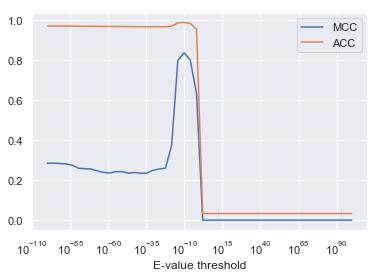

In [81]:
plot_MCC(p_train_vals, n_train_vals)

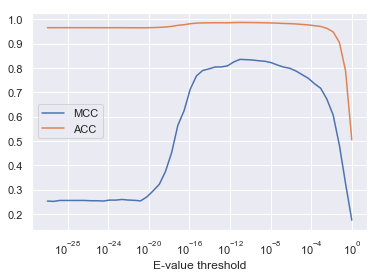

In [82]:
plot_MCC(p_train_vals, n_train_vals, -30, 0)

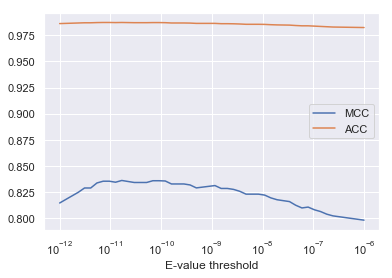

In [83]:
plot_MCC(p_train_vals, n_train_vals, -12, -6)

We can see that the MCC is near-random until 1e-27, then there is a sharp increase followed by a peak and a decrease.
We most probably want an MCC around 1e-10.
But let's determine it analitycally.

We could write down a simple univariate linear regression, but there is a function already available in scipy.
I just need to write a cost function in a form which can be used by the minimization algorithm.

In [84]:
import scipy.optimize as opt

def objective_fun_MCC(thr, p_vals, n_vals, mock=None): # mock is needed so that I don't get an error when I pass to it the windowsize parameter (see next)
    MCC = get_MCC(thr, p_vals, n_vals)
    cost = 1-abs(MCC)
    return cost

def maximize_MCC(p_vals, n_vals, fun_MCC, window_size=None):
    result = opt.minimize_scalar(fun_MCC, args=(p_vals, n_vals, window_size))
    optimal_thr = result.x
    return optimal_thr

In [85]:
training_thr = maximize_MCC(p_train_vals, n_train_vals, objective_fun_MCC)
"{:e}".format(training_thr) # just to print in scientific notation

'1.186242e-03'

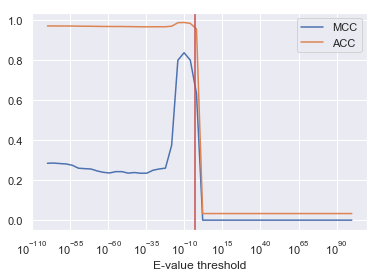

In [86]:
plot_MCC(p_train_vals, n_train_vals, -100, 100, training_thr)

**This** is NOT what he expected.
The function is really bumpy. He is making his algorithm work better by making it smoother with a sliding window.


In [88]:
def smoot_MCC(thr, p_vals, n_vals, window_size=1):
    x = thr
    log_x = np.log10(x)
    smooth_window = np.logspace(log_x-window_size/2,log_x+window_size/2)
    window_res = []
    for log_x_w in smooth_window:
        window_res.append(get_MCC(log_x_w, p_vals, n_vals))
    smooth_fun = -abs(sum(window_res)/len(window_res)) # need to be negative for minimization
    return smooth_fun


training_thr_smooth = maximize_MCC(p_train_vals, n_train_vals, smoot_MCC, 1) # smoothing with window size of 1
"{:e}".format(training_thr_smooth) # just to print in scientific notation

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:117: RuntimeWarning: invalid value encountered in double_scalars
  delta = stop - start
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


'3.553190e-11'

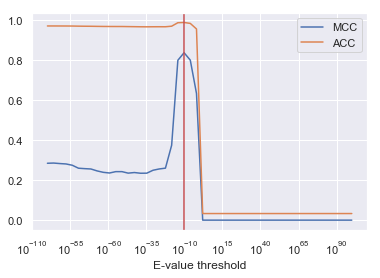

In [89]:
plot_MCC(p_train_vals, n_train_vals, -100, 100, training_thr_smooth)

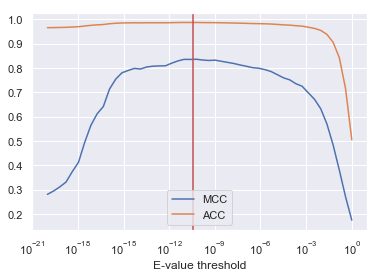

In [90]:
plot_MCC(p_train_vals, n_train_vals, -20, 0, training_thr_smooth)

Now it is better

# Evaluation of the method on the test set
To evaluate how good my discrimination method is, I use the threshold of 1.18e-03 on the test set and determine the various statistics.
Just for simplicity I wrap all the various parsing operations in one function.

First I need to select the top-hits for each sequence also for the negative testing set.
The positive set is the same as the positive training set so it is not needed.

In [96]:
!cat negative_training.bl6|awk \
'{\
query=$1;\
if (!(query in out) || $11 < evalue[query])\
    {evalue[query]=$11; out[query]=$0}\
}\
END{for(key in out){print out[key]}}'\
> negative_testing_topscores.bl6

Just for simplicity I wrap all the various parsing operations in one function

In [94]:
def get_vals(blast_filepath, fasta_filepath):
    df = get_blasttab_df(blast_filepath)
    with open(fasta_filepath) as fasta_file:
        num_seqs = 0
        for line in fasta_file:
            if line[0] == ">":
                num_seqs += 1
    vals = blast_complete_array(np.array(df[10]),num_seqs)
    return vals

Finally, let's see what happens!

In [97]:
n_test_vals = get_vals("./negative_testing_topscores.bl6","./Human_NotPF00014_Testing.fasta")
p_test_vals = get_vals("./positive_training_test_topscores.bl6","./NotHuman_PF00014.fasta")
get_stats(training_thr_smooth, p_test_vals, n_test_vals)
pass # just to avoid the print of the array by jupyter

Confusion matrix:

[[  331   124]
 [10223    10]] 

Threshold: 3.553189604039684e-11
ACC: 0.9874625748502994
MCC: 0.8345561820014149
